# Lake model continued - sensitivity analysis

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the separate anthropogenic release decision**

There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis.

## 1. SOBOL
1. Apply Sobol with 3 separate release policies (0, 0.05, and 0.1) and analyse the results for each release policy separately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each separate release policy and apply sobol to each of the three separate release policies. If this sounds too complicated, just do it on each release policy separately.*

In [13]:
from lakemodel_function import lake_problem

import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter,  perform_experiments, ema_logging, ScalarOutcome, Policy, Samplers)
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol



# Instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100

# Specify uncertainties
lake_model.uncertainties = [
        RealParameter("b", 0.1, 0.45),
        RealParameter("q", 2.0, 4.5),
        RealParameter("mean", 0.01, 0.05),
        RealParameter("stdev", 0.001, 0.005),
        RealParameter("delta", 0.93, 0.99),
    ]

# Set levers, one for each time step
lake_model.levers = [RealParameter('l'+str(i), 0, 0.1) for i in range(lake_model.time_horizon)]

# Specify outcomes
lake_model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability"),
    ]

#release 0 for all level points
lake_model.policies = [
    Policy('0', **{l.name:0 for l in lake_model.levers}),
    Policy('0.05', **{l.name:0.05 for l in lake_model.levers}),
    Policy('0.1', **{l.name:0.1 for l in lake_model.levers})]
    

##### Run Experiments with Sobol Sampling

In [37]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model, n_processes=7) as evaluator:
    experiments, results = evaluator.perform_experiments(100, lake_model.policies,
                                                         uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 7 workers
c:\Users\ryant\miniconda3\envs\ema\Lib\site-packages\SALib\sample\sobol.py:132: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  base_sequence = qrng.random(N)
[MainProcess/INFO] performing 1200 scenarios * 3 policies * 1 model(s) = 3600 experiments
100%|█████████████████████████████████████| 3600/3600 [00:05<00:00, 685.48it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


##### Analyze

In [11]:
problem = get_SALib_problem(lake_model.uncertainties)
problem

{'num_vars': 5,
 'names': ['b', 'delta', 'mean', 'q', 'stdev'],
 'bounds': [(0.1, 0.45),
  (0.93, 0.99),
  (0.01, 0.05),
  (2.0, 4.5),
  (0.001, 0.005)]}

In [38]:
experiments.head(5)

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.293655,0.932594,0.039427,3.159952,0.004554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25200,0,lakeproblem
1,0.168805,0.932594,0.039427,3.159952,0.004554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25201,0,lakeproblem
2,0.293655,0.986217,0.039427,3.159952,0.004554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25202,0,lakeproblem
3,0.293655,0.932594,0.011906,3.159952,0.004554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25203,0,lakeproblem
4,0.293655,0.932594,0.039427,3.141286,0.004554,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25204,0,lakeproblem


In [73]:
# process sobol results

sobol_results = {}
for policy in experiments.policy.unique():
    
    # Only subset outcome based on scenarios of the policy
    logical = experiments.policy == policy
    y = results['reliability'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

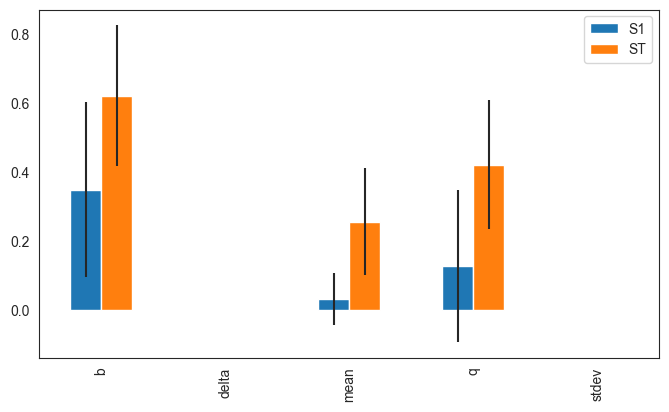

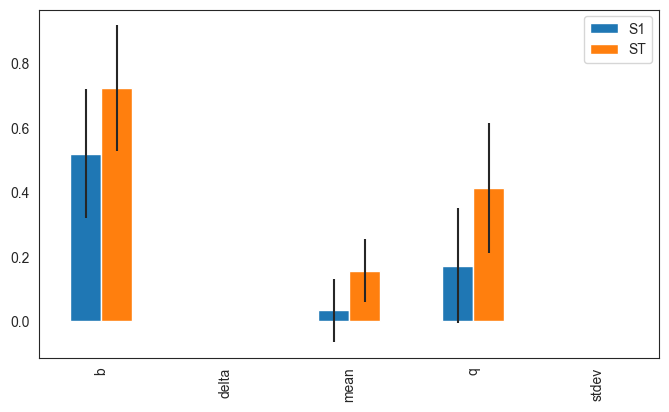

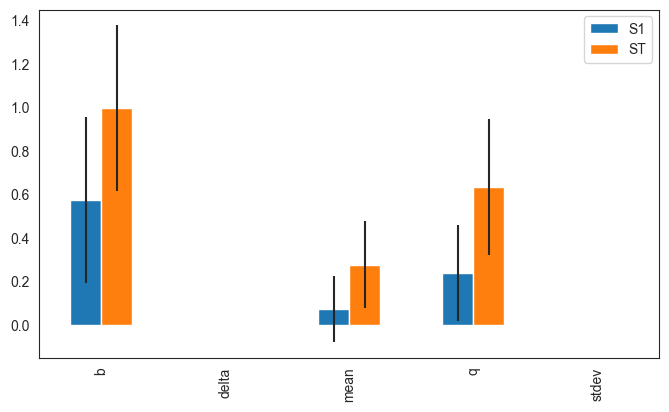

In [62]:
import pandas as pd
import seaborn as sns

# visualize sobol indices

for policy in experiments.policy.unique():
    Si = sobol_results[policy]
    Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter_s1_st, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

## 2. Feature scoring
Repeat the above analysis for the 3 release policies but now with extra trees [feature scoring](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results. See also the [features scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) section of the tutorial.*


In [74]:
from ema_workbench.analysis import feature_scoring

results

{'max_P': array([0.14299997, 6.13913195, 0.14334329, ..., 2.99924432, 2.98754233,
        2.98781533]),
 'utility': array([0.        , 0.        , 0.        , ..., 0.73413835, 0.73413835,
        0.73413835]),
 'inertia': array([0., 0., 0., ..., 0., 0., 0.]),
 'reliability': array([1.    , 0.2819, 1.    , ..., 0.11  , 0.1   , 0.1   ])}

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


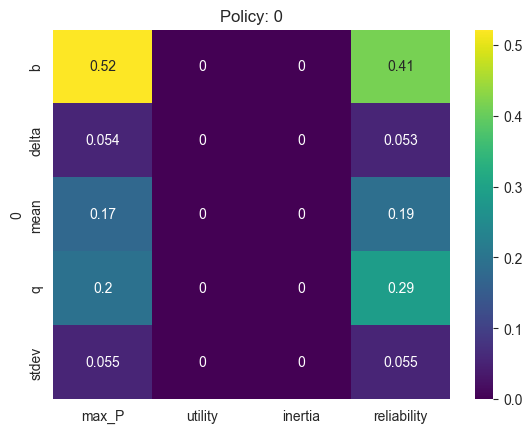

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


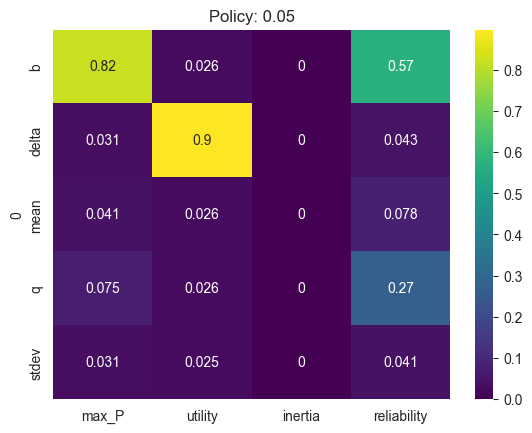

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category


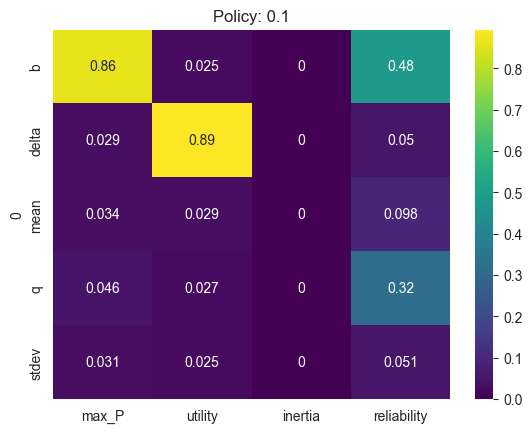

In [79]:
exp = experiments.drop(columns=[l.name for l in lake_model.levers]).drop(columns='model')

for policy in experiments.policy.unique():
    
    # Only subset outcome based on scenarios of the policy
    logical = experiments.policy == policy
    sub_results = {key:value[logical] for key,value in results.items()}

    scores = feature_scoring.get_feature_scores_all(exp[logical], sub_results)

    # Plot Heatmap
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.title("Policy: " + policy)
    plt.show()